In [ ]:
file_num = int(input('Enter a random number between 0 and 24739: '))

Enter a random number between 0 and 24739: 14569


In [ ]:
import sys
import os
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow as show
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras.backend as K

In [ ]:
print(tf.__version__)

2.12.0


In [ ]:
print(keras.__version__)

2.12.0


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.layers import Input, Dense, GlobalAveragePooling1D, Reshape, Conv2D, concatenate
import sys
sys.path.append('/content/drive/MyDrive/439D PROJECT/swin transformer repo/keras-vision-transformer')

from keras_vision_transformer import swin_layers
from keras_vision_transformer import transformer_layers
def swin_transformer_stack(X, stack_num, embed_dim, num_patch, num_heads, window_size, num_mlp, shift_window=True, name=''):

    # Turn-off dropouts
    mlp_drop_rate = 0 # Droupout after each MLP layer
    attn_drop_rate = 0 # Dropout after Swin-Attention
    proj_drop_rate = 0 # Dropout at the end of each Swin-Attention block, i.e., after linear projections
    drop_path_rate = 0 # Drop-path within skip-connections
    
    qkv_bias = True # Convert embedded patches to query, key, and values with a learnable additive value
    qk_scale = None # None: Re-scale query based on embed dimensions per attention head # Float for user specified scaling factor
    
    if shift_window:
        shift_size = window_size // 2
    else:
        shift_size = 0
    
    for i in range(stack_num):
    
        if i % 2 == 0:
            shift_size_temp = 0
        else:
            shift_size_temp = shift_size

        X = swin_layers.SwinTransformerBlock(dim=embed_dim, 
                                             num_patch=num_patch, 
                                             num_heads=num_heads, 
                                             window_size=window_size, 
                                             shift_size=shift_size_temp, 
                                             num_mlp=num_mlp, 
                                             qkv_bias=qkv_bias, 
                                             qk_scale=qk_scale,
                                             mlp_drop=mlp_drop_rate, 
                                             attn_drop=attn_drop_rate, 
                                             proj_drop=proj_drop_rate, 
                                             drop_path_prob=drop_path_rate, 
                                             name='name{}'.format(i))(X)
    return X

def swin_unet_2d_base(input_tensor, filter_num_begin, depth, stack_num_down, stack_num_up, 
                      patch_size, num_heads, window_size, num_mlp, shift_window=True, name='swin_unet'):

    # Compute number be patches to be embeded
    input_size = input_tensor.shape.as_list()[1:]
    num_patch_x = input_size[0]//patch_size[0]
    num_patch_y = input_size[1]//patch_size[1]
    
    # Number of Embedded dimensions
    embed_dim = filter_num_begin
    
    depth_ = depth
    
    X_skip = []

    X = input_tensor
    
    # Patch extraction
    X = transformer_layers.patch_extract(patch_size)(X)

    # Embed patches to tokens
    X = transformer_layers.patch_embedding(num_patch_x*num_patch_y, embed_dim)(X)
    
    # The first Swin Transformer stack
    X = swin_transformer_stack(X, 
                               stack_num=stack_num_down, 
                               embed_dim=embed_dim, 
                               num_patch=(num_patch_x, num_patch_y), 
                               num_heads=num_heads[0], 
                               window_size=window_size[0], 
                               num_mlp=num_mlp, 
                               shift_window=shift_window, 
                               name='{}_swin_down0'.format(name))
    X_skip.append(X)
    
    # Downsampling blocks
    for i in range(depth_-1):
        
        # Patch merging
        X = transformer_layers.patch_merging((num_patch_x, num_patch_y), embed_dim=embed_dim, name='down{}'.format(i))(X)
        
        # update token shape info
        embed_dim = embed_dim*2
        num_patch_x = num_patch_x//2
        num_patch_y = num_patch_y//2
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, 
                                   stack_num=stack_num_down, 
                                   embed_dim=embed_dim, 
                                   num_patch=(num_patch_x, num_patch_y), 
                                   num_heads=num_heads[i+1], 
                                   window_size=window_size[i+1], 
                                   num_mlp=num_mlp, 
                                   shift_window=shift_window, 
                                   name='{}_swin_down{}'.format(name, i+1))
        
        # Store tensors for concat
        X_skip.append(X)
        
    # reverse indexing encoded tensors and hyperparams
    X_skip = X_skip[::-1]
    num_heads = num_heads[::-1]
    window_size = window_size[::-1]
    
    # upsampling begins at the deepest available tensor
    X = X_skip[0]
    
    # other tensors are preserved for concatenation
    X_decode = X_skip[1:]
    
    depth_decode = len(X_decode)
    
    for i in range(depth_decode):
        
        # Patch expanding
        X = transformer_layers.patch_expanding(num_patch=(num_patch_x, num_patch_y), 
                                               embed_dim=embed_dim, 
                                               upsample_rate=2, 
                                               return_vector=True)(X)
        

        # update token shape info
        embed_dim = embed_dim//2
        num_patch_x = num_patch_x*2
        num_patch_y = num_patch_y*2
        
        # Concatenation and linear projection
        X = concatenate([X, X_decode[i]], axis=-1, name='{}_concat_{}'.format(name, i))
        X = Dense(embed_dim, use_bias=False, name='{}_concat_linear_proj_{}'.format(name, i))(X)
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, 
                                   stack_num=stack_num_up, 
                                   embed_dim=embed_dim, 
                                   num_patch=(num_patch_x, num_patch_y), 
                                   num_heads=num_heads[i], 
                                   window_size=window_size[i], 
                                   num_mlp=num_mlp, 
                                   shift_window=shift_window, 
                                   name='{}_swin_up{}'.format(name, i))
        
    # The last expanding layer; it produces full-size feature maps based on the patch size
    # !!! <--- "patch_size[0]" is used; it assumes patch_size = (size, size)
    
    X = transformer_layers.patch_expanding(num_patch=(num_patch_x, num_patch_y), 
                                           embed_dim=embed_dim, 
                                           upsample_rate=patch_size[0], 
                                           return_vector=False)(X)
    
    return X

#hyperparameters
filter_num_begin = 128     # number of channels in the first downsampling block; it is also the number of embedded dimensions
depth = 4                  # the depth of SwinUNET; depth=4 means three down/upsampling levels and a bottom level 
stack_num_down = 2         # number of Swin Transformers per downsampling level
stack_num_up = 2           # number of Swin Transformers per upsampling level
patch_size = (4, 4)        # Extract 4-by-4 patches from the input image. Height and width of the patch must be equal.
num_heads = [4, 8, 8, 8]   # number of attention heads per down/upsampling level
window_size = [4, 2, 2, 2] # the size of attention window per down/upsampling level
num_mlp = 512              # number of MLP nodes within the Transformer
shift_window=True          # Apply window shifting, i.e., Swin-MSA

input_size = (256,256,1)
IN = Input(input_size)

# Base architecture
X = swin_unet_2d_base(IN, filter_num_begin, depth, stack_num_down, stack_num_up, 
                      patch_size, num_heads, window_size, num_mlp, 
                      shift_window=shift_window, name='swin_unet')

# Output section
n_labels = 1
OUT = Conv2D(n_labels, kernel_size=1, use_bias=False, activation='sigmoid')(X)

# Model configuration
model = keras.models.Model(inputs=[IN,], outputs=[OUT,])

model.summary()

opt = keras.optimizers.Adam(learning_rate=1e-4, clipvalue=0.5)
#model.compile(loss=dice_coef_loss,
#              optimizer=opt,
#              metrics=[tf.keras.metrics.Accuracy(),tf.keras.metrics.BinaryIoU(),tf.metrics.Precision(),tf.keras.metrics.Recall()])
#keras.losses.BinaryCrossentropy()

model.load_weights('/content/drive/MyDrive/439D PROJECT/swin_transformer_model')

model.compile(loss=iou_loss,
              optimizer=opt,
              metrics=[accuracy,tf.keras.metrics.BinaryIoU(target_class_ids=[1]),precision,recall,F1_score])






Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 patch_extract (patch_extract)  (None, 4096, 16)     0           ['input_1[0][0]']                
                                                                                                  
 patch_embedding (patch_embeddi  (None, 4096, 128)   526464      ['patch_extract[0][0]']          
 ng)                                                                                              
                                                                                          

In [ ]:
def accuracy(y_true,y_pred):
  accuracy = K.sum(tf.cast((y_true==y_pred),tf.float32))/tf.cast(K.prod(K.shape(y_true)),tf.float32)
  return accuracy

def IoU(y_true,y_pred):
  true_pos = K.sum(K.round(K.clip(y_true*y_pred,0,1)))
  #print("True pos: ", true_pos)
  total_pos = K.sum(K.round(K.clip(y_pred,0,1)))
  #print("total pos: ", total_pos)
  ground_pos = K.sum(y_true)
  #print("ground truth positive:",ground_pos)
  false_pos = total_pos - true_pos
  #print("false pos", false_pos)
  false_neg = ground_pos - true_pos
  #print("false neg", false_neg)
  IoU = (true_pos)/(true_pos + false_pos + false_neg + K.epsilon())
  return IoU

def precision(y_true,y_pred):
  true_pos = K.sum(K.round(K.clip(y_true*y_pred,0,1)))
  total_pos = K.sum(K.round(K.clip(y_pred,0,1)))
  precision = true_pos/(total_pos + K.epsilon())
  return precision

def recall(y_true,y_pred):
  true_pos = K.sum(K.round(K.clip(tf.cast(y_true,tf.float32)*y_pred,0,1)))
  ground_pos = K.sum(y_true)
  recall = true_pos/(ground_pos + K.epsilon())
  return recall

def F1_score(y_true,y_pred):
  prec = precision(y_true,y_pred)
  rec = recall(y_true,y_pred)
  F1_score = (2*prec*rec)/(prec+rec + K.epsilon())
  return F1_score

  def class_weight(labels):
    building_ratio = sum(sum(sum(labels)))/(labels.shape[0]*256*256)
    return building_ratio


def dice_coef(y_true, y_pred):
  smooth = 1
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(tf.cast(y_true_f,tf.float32)* y_pred_f)
  return (2. * intersection + smooth) / (K.sum(tf.cast(y_true_f,tf.float32)) + K.sum(y_pred_f) + smooth)
    
    
def dice_coef_loss(y_true, y_pred):
  return 1 - dice_coef(y_true, y_pred)

def compound_loss(y_true,y_pred):
  return 0.9*dice_coef_loss(y_true,y_pred)+ 0.1*K.binary_crossentropy(y_true, y_pred)

def weighted_bce(y_true,y_pred):
  num_pred = K.sum(K.cast(y_pred < 0.5, y_true.dtype)) + K.sum(y_true)    
  zero_weight =  K.sum(y_true)/ num_pred +  K.epsilon() 
  one_weight = K.sum(K.cast(y_pred < 0.5, y_true.dtype)) / num_pred +  K.epsilon()
  weights =  (1.0 - y_true) * zero_weight +  y_true * one_weight 
  bin_crossentropy = K.binary_crossentropy(y_true, y_pred)
  weighted_bin_crossentropy = weights * bin_crossentropy 
  return K.mean(weighted_bin_crossentropy)

In [ ]:
custom_objects = {"precision": precision, "recall": recall, "F1_score": F1_score, "compound_loss": compound_loss, "dice_coef": dice_coef, "dice_coef_loss": dice_coef_loss}
unet = tf.keras.models.load_model('/content/drive/MyDrive/439D PROJECT/unet_model', custom_objects = custom_objects)

In [ ]:
labels = np.load('/content/drive/MyDrive/439D PROJECT/processed data/labels_final.npy')
imgs = np.load('/content/drive/MyDrive/439D PROJECT/processed data/imgs_final.npy')

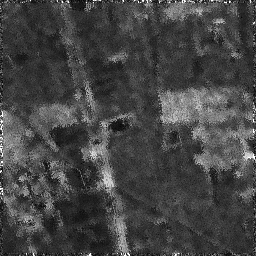

1/1 [==============================] - 1s 548ms/step
UNET prediction:


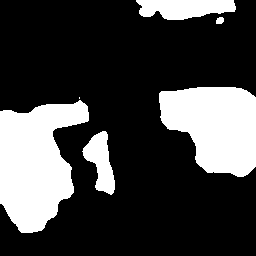

Swin prediction:


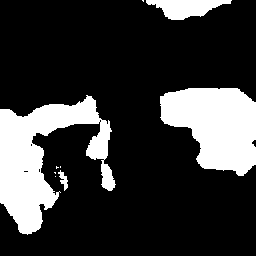

Label: 


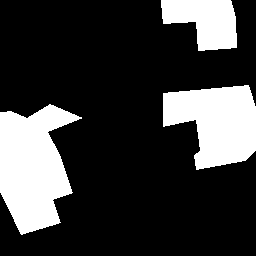

IoU UNET:  0.7182964
IoU SWIN:  0.6619045


In [ ]:
test_img = imgs[file_num]/255.0
show(imgs[file_num])

swin_predict = model.predict(np.array([test_img]))
label_predict = unet.predict(np.array([test_img]))
print("UNET prediction:")
unet_prediction_image = 255*np.round(label_predict[0],0)
show(unet_prediction_image)
print("Swin prediction:")
swin_prediction_image = 255*np.round(swin_predict[0],0)
show(swin_prediction_image)
print("Label: ")
show(255*labels[file_num])

UNET_IoU = tf.keras.metrics.BinaryIoU(target_class_ids=[1])
UNET_IoU.update_state(labels[file_num], label_predict[0])

SWIN_IoU = tf.keras.metrics.BinaryIoU(target_class_ids=[1])
SWIN_IoU.update_state(labels[file_num], swin_predict[0])
print("IoU UNET: ", UNET_IoU.result().numpy())

print("IoU SWIN: ", SWIN_IoU.result().numpy())